# Real Estate - advanced estimator

In the previous challenge we saw that if we have more flats than features in our dataset then we can't "solve" the equation $X\theta = Y$ to find a deterministic formula for $\theta$ and thus predict flat price this way.

In this exercise we now have access to a bigger dataset consisting of 1000 flats and we want to refine our prediction for the same new flat as before:

- `Surface`: 3000 $ft^2$
- `Bedrooms`: 5 
- `Floors`: 1

Instead of solving $X\theta = Y$ with a matrix $X$ of shape (1000,4) non-inversible, we will find the $\hat{\theta}$ that minimizes the error $e = X\hat{\theta} - Y $: this approach is called a **linear regression model**. We will measure this error $e$ using the euclidian distance $\left\|e\right\|$ and the Mean Square Error.

Let's compute $\hat{\theta}$ to find an approximate estimation of the new flat's price.


In [2]:
# import default libraries
# You can now use pandas again to manipulate the dataframe easily
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Exploration

Load the dataset `flats.csv` located in the notebook's folder, into a pandas DataFrame named "flats"

In [4]:
# YOUR CODE HERE
flats = pd.read_csv("flats.csv")
flats

,price,bedrooms,surface,floors
0,274.0,3,1830,2.0
1,500.0,4,2120,1.0
2,320.0,3,1260,1.0
3,445.5,3,1880,1.0
4,637.5,3,1680,1.0
...,...,...,...,...
995,700.0,9,3680,2.0
996,272.0,3,1528,2.0
997,350.0,3,1050,1.0
998,649.0,4,2980,2.0


Use scatterplots to visually figure out which feature gives the most information about prices:

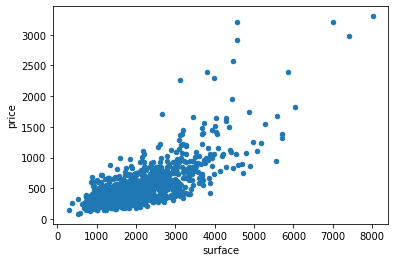

In [14]:
# YOUR CODE HERE
flats.plot.scatter('surface', 'price');

It seems that `surface` is a stronger indicator of price than the number of bedrooms or floors. In statistics, we say that `prices` are more **correlated** with `surface` than with other features. 

Let's double check this by running [`pandas.DataFrame.corr`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) below, which computes correlation coefficients between each pair of columns of a DataFrame. 1 means perfectly correlated, while 0 means not correlated at all.

In [18]:
# YOUR CODE HERE
pd.DataFrame.corr(flats)

,price,bedrooms,surface,floors
price,1.000000,0.239623,0.732790,0.258263
bedrooms,0.239623,1.000000,0.417170,0.131993
surface,0.732790,0.417170,1.000000,0.357512
floors,0.258263,0.131993,0.357512,1.000000


### Test your code!

In [19]:
from nbresult import ChallengeResult

result = ChallengeResult('flats',
    shape=flats.shape,
    columns=flats.columns
)
result.write()
print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.12, pytest-6.2.5, py-1.10.0, pluggy-1.0.0 -- /home/useradd/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/useradd/code/LucaVanTichelen/data-challenges/03-Maths/01-Algebra-Calculus/02-real-estate-advanced-estimator
plugins: dash-2.0.0, anyio-3.3.2
collecting ... collected 2 items

tests/test_flats.py::TestFlats::test_columns PASSED                      [ 50%]
tests/test_flats.py::TestFlats::test_shape PASSED                        [100%]

============================== 2 passed in 0.29s ===============================


💯 You can commit your code:

git add tests/flats.pickle

git commit -m 'Completed flats step'

git push origin master


## 2. Estimator with 1 feature

Let's try to build a statistical estimator of `price` only as a function of `surface`.

Let's try to fit a **linear regression** between the two variables. Practically speaking, we want to choose the best parameters $\hat{\theta}$ = (`slope`, `intercept`) such that the `slope * surface + intercept` is as close as possible to the `price` in terms of Mean Square Error.

👉During the next weeks we will learn different models (Linear Regression, KNN, Logistic Regression, Neural Networks, etc.). An important part of your job is choosing the right model and optimizing the parameters to make the best predictions.

### 2.1 Visual approach

Implement the function `plot_line(slope, intercept, ax)` that plots a line with the slope and intercept arguments on the ax figure. We added the argument ax, so you can plot the line(s) on your scatterplot.
When you are done, play with different values for slope and intercept in order to get a “good linear approximation” of the data. Can you find the best fit?

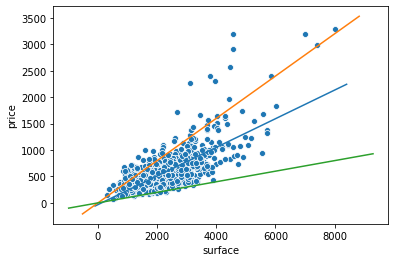

Not so easy (and not very “scientific”), right?

In [83]:
def plot_line(a, b, ax):
    """Plot a line from slope and intercept on the ax"""
    x1, x2 = ax.get_xlim()
    y1, y2 = a * x1 + b, a * x2 + b
    return plt.plot([x1,x2], [y1,y2])

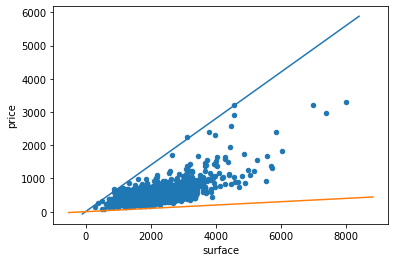

In [88]:
# TO DO: play with slopes and intercepts to get the best fit
ax = flats.plot.scatter('surface', 'price');
plot_line(0.7, 0, ax);
plot_line(0.05, 0, ax);

### 2.2 Computational approach

To be sure that our estimator line is the best possible one, we need to compute  the **Mean Squared Error** between `price` and `predicted_price (slope * surface + intercept)`. Remember those are vectors of shape (1000,1).

**Step1:** for each row (ie. flat), we should evaluate the squared_error (predicted_price - price)**2

In [234]:
def squared_errors(slope, intercept, surfaces, prices):
    """TO DO: return an array containing the squared errors between 
    all predicted_prices and the actual prices (from the dataset)
    """
    predicted_price = slope * surfaces + intercept
    return (predicted_price - prices)**2

**Step2:** return the mean of the array returned from the `squared_errors` function

In [235]:
def mse(slope, intercept, surfaces, prices):
    '''TO DO: Return the mean of the array contained in squared_errors as a float.'''
    return np.mean(squared_errors(slope, intercept, surfaces, prices))

Try to compute the MSE of one estimator of your choice

In [236]:
# YOUR CODE HERE
mse(1, 1, flats['surface'], flats['price'])

3016076.431314907

### 2.3 Finding the best parameters

Play with different values for `slope` and `intercept` and try to get the best fit by hand!  
Notice how hard it is to optimize both parameters at the same time.
Follow the step below to get an idea of one potential approach:

#### Step ①: Start by fixing an  `initial_intercept` with your best estimate, then find an approximated min slope for `mse=f(slope)`

In [261]:
# Define an initial_intercept, for instance, we may suppose there is always a small transaction fee even for very small flats?
initial_intercept = 100
mse(0, initial_intercept, flats['surface'], flats['price'])

# Create a range of 100 slopes which contains what you believe is the optimal slope (hint: np.linspace())
slopes = np.linspace(0, 0.5, 100)

# Create the list of MSEs for each slope value
mses = [mse(slope, initial_intercept, flats['surface'], flats['price']) for slope in slopes]

Plot MSEs against slopes. Do you see a minimum? If not, try another range of slopes!

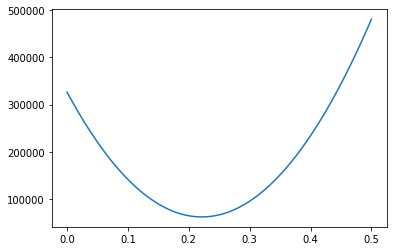

In [262]:
plt.plot(slopes, mses);

Compute the min value of MSEs for your `initial_intercept`, and the corresponding `slope_best` value

<br>
<details>
    <summary>Hint 💡</summary>
        here you can use python's built-in `min()` function, as well as `List.index()` method
</details>

In [266]:
best_slope = slopes[mses.index(min(mses))]
best_slope

0.22222222222222224

#### Step ②: Let's now fix the slope to that `slope_best` value, then re-use the previous approach to find `a` and a new `intercept_best` approximation

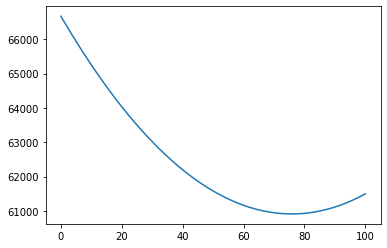

In [267]:
# Create a range of 100 intercepts which contains what you believe is the optimal intercept
intercepts = np.linspace(0, 100, 100)

# Create the list of MSEs for each intercept value
news = [mse(best_slope, intercept, flats['surface'], flats['price']) for intercept in intercepts]

# Plot MSEs against slopes. Do you see a minimum? If not, try another range of slopes!
plt.plot(intercepts, news);

Compute the min value of MSEs for `slope = slope_best` and store the corresponding best intercept as `intercept_best`


In [268]:
intercept_best = intercepts[news.index(min(news))]
intercept_best

75.75757575757576

**Great job**! By adding a non-zero intercept parameter, we have been able to reduce the MSE even more (Feel free to plot the regression line in your scatter plot to "visually" confirm the approximate fit).

❓ However, what guarantees that these (`intercept_best`, `slope_best`) parameters are really the best ones? 

<details>
    <summary>🔥 Explanations </summary>
    
We could maybe find an even better slope value by repeating step ①, this time fixing intercept at `intercept_best`! And then repeat step ② with the new slope to adjust the intercept again...
    
In order to find the global minimum of a 2-parameter function RMSE = f(slope, intercept), we may have to repeat step ① and ② indefinitely until values converge towards absolute minimums - and with no guarantee of success.
    
<img src='https://raw.githubusercontent.com/lewagon/data-images/master/decision-science/real-estate-minimizer.png'>
    
💪 You just discovered one of the fundamental aspects of machine learning: **iterative process for finding mimina**.  

👉 As you can guess, in the Data Scientist world, algorithms have been developed to automate and optimize such processes. In the next few weeks, you will discover the power of other algorithms such as **Gradient Descent**, and Python libaries such as `Stastmodels` that perform this iterative process for you. 

</details>



❓Run the cells below if you are curious and want to find the absolute best slope and intercept for this dataset, computed using gradient descent.

<AxesSubplot:xlabel='surface', ylabel='price'>

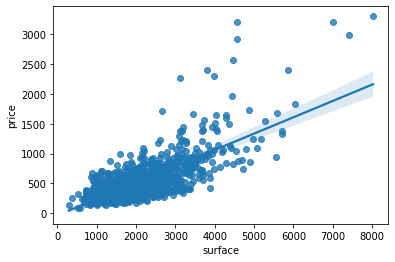

In [186]:
# Try this out (seaborn visual solution)
sns.regplot(data=flats, x='surface', y='price')

In [269]:
# Try this out (statsmodels, exact solution)!
import statsmodels.formula.api as smf
regression = smf.ols(formula= 'price ~ surface', data=flats).fit()
regression.params

Intercept   -33.308336
surface       0.273690
dtype: float64

Let's get back to our initial question: What is your new prediction for the 5th flat below? How does it compare with your initial prediction based only on 4 flats? 

- `surface`: 3000 $ft^2$
- `bedrooms`: 5 
- `floors`: 1

In [188]:
# compute predicted price (Remember that the real price is 750,000$)
print('predicted price: ', regression.params['surface']*3000 + regression.params['Intercept'])

predicted price:  787.7629605753169


It's better than our initial deterministic estimator based on only 4 flats, but obviously we miss the information provided by the number of bedrooms and floors in this prediction.

### Check your code

In [270]:
from nbresult import ChallengeResult

result = ChallengeResult('univariate',
    squared_errors=squared_errors(10, 0, np.array([40, 20]), np.array([400, 200])),
    mse=mse(10, 0, np.array([40, 20]), np.array([400, 200])),
    theta1=slope_best,
    theta0=intercept_best
)
result.write()
print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.12, pytest-6.2.5, py-1.10.0, pluggy-1.0.0 -- /home/useradd/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/useradd/code/LucaVanTichelen/data-challenges/03-Maths/01-Algebra-Calculus/02-real-estate-advanced-estimator
plugins: dash-2.0.0, anyio-3.3.2
collecting ... collected 4 items

tests/test_univariate.py::TestUnivariate::test_best_intercept PASSED     [ 25%]
tests/test_univariate.py::TestUnivariate::test_best_slope PASSED         [ 50%]
tests/test_univariate.py::TestUnivariate::test_mse PASSED                [ 75%]
tests/test_univariate.py::TestUnivariate::test_squared_errors PASSED     [100%]

============================== 4 passed in 0.14s ===============================


💯 You can commit your code:

git add tests/univariate.pickle

git commit -m 'Completed univariate step'

git push origin master


## 3 Estimator with all features (surface, bedrooms, floors)?

Linear regression with three features works the same way as with one feature, but instead of determining only the  parameters to minimize RMSE (`intercept` and `slope`), we'll need to find 4 parameters: $\hat{\theta}$ = (`intercept`, `slope_surface`, `slope_bedrooms`, `slope_floors`). 

The same gradient iterative method is applicable, and you will code it yourself by hand during the next few weeks.
Meanwhile, feel free to run the cell below to see the final result of this multivariate regression:

In [271]:
# Find the four regression coefficients by running this cell
import statsmodels.formula.api as smf
regression = smf.ols(formula= 'price ~ surface + bedrooms + floors', data=flats).fit()
regression.params

Intercept    18.154854
surface       0.286953
bedrooms    -21.623564
floors       -3.811868
dtype: float64

In [272]:
# Compute the newly predicted price for the 5th flat? Is this prediction better?
regression.params['Intercept'] +\
regression.params['surface']*3000 +\
regression.params['bedrooms']*5 +\
regression.params['floors']*1

767.0851073102862

<details>
    <summary><bold>🔎 Concluding remarks (linear algebra)</bold> </summary>


This optimisation problem can be summarized as follows: we need to find a vector of parameters $\hat{\theta}$ (slope + intercept) that minimizes an error $e = \left\|X\hat{\theta} - Y \right\|^2$, for a given matrix of features $X$ (surfaces, floors, bedrooms) and a vector of observations $Y$ (prices)

Such minimum $\hat{\theta}$ is reached when the "derivatives" of $e$, that is $2 X^T(X\hat{\theta}−Y)$ equals zero (proof next week). In other words, we need to solve the linear system $(X^TX)\hat{\theta}=X^TY$. It has has a unique solution provided that no column of X can be expressed as a linear combination of the others: in that case $(X^TX)^{-1}$ is invertible and the minimum is reached when $\hat{\theta} = (X^TX)^{-1} X^T Y$. Notice how X does not need to be squared anymore compared to the first challenge.

Keep in mind, however, that inverting matrices is **computationally complex**. That is why other methods have been developed to find the minimum, such as **gradient descent**. Read more on [stack overflow](https://stats.stackexchange.com/a/278779) if you are interested!
</details>


🏁 Congratulations! Don't forget to commit and push your notebook!